In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import imread
import json
import gzip
import tarfile
import random
%matplotlib inline
plt.rcParams['image.cmap'] = 'Greys'

print("packs loaded")

In [2]:
index_data_en = []

with gzip.open('data/en/index.json.gz', 'rt') as arc:
    index_data_en.extend(json.load(arc))
    print("en index loaded")
    
with tarfile.open('data/en/data.tar.gz', "r|*") as tar:
    print("tar opened")
    img_data_en = []
    for i, member in enumerate(index_data_en):
        if i%10000 == 1:
            print("%2.0f%% complete (%d / %d)" % (i / len(index_data_en) * 100, i, len(index_data_en)))
        ti = tar.next()
        if ti.name != member['path']:
            print("ERROR: order doesn't match")
            break;
        f = tar.extractfile(ti)
        img_data_en.append(1 - (imread(f)/255))
    img_en = np.array(img_data_en)
    del img_data_en
    print("en image loaded")

en index loaded
tar opened
 0% complete (1 / 79200)
13% complete (10001 / 79200)
25% complete (20001 / 79200)
38% complete (30001 / 79200)
51% complete (40001 / 79200)
63% complete (50001 / 79200)
76% complete (60001 / 79200)
88% complete (70001 / 79200)
en image loaded


In [3]:
en_chset = []
en_chset.extend(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
en_chset.extend(["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n",\
              "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"])
en_chset.extend(["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N",\
              "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"])
en_chset.extend(["(", ")", "'", "\"", ".", ",", ":", ";", "!", "?", "/", "@", "#", "$",\
              "%", "^", "&", "*", "[", "]", "{", "}", "<", ">", "~", "-"])

label_en = np.zeros([img_en.shape[0], len(en_chset)])
for i, member in enumerate(index_data_en):
    label_en[i][en_chset.index(member['target'])] = 1
    
print("en label loaded")

en label loaded


In [4]:
def getIndex(l, indexes):
    return [l[i] for i in indexes]

def shuffle(n, *lists):
    perm = np.random.permutation(n)
    lists = list(lists)
    for i in range(len(lists)):
        if hasattr(lists[i], "shape"):
            lists[i] = lists[i][perm]
        else:
            lists[i] = getIndex(lists[i], perm)
    return tuple(lists)

img_en, label_en, index_data_en = shuffle(img_en.shape[0], img_en, label_en, index_data_en)

print("shuffled")

shuffled


(79200, 32, 32)
{'target': 'j', 'weight': 'NORMAL', 'path': '0017316.png', 'font': 'NanumGothic'}
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


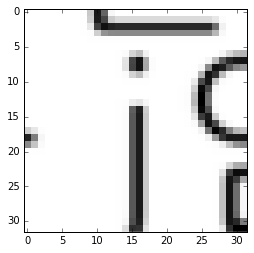

In [5]:
print(img_en.shape)
plt.figure()
plt.imshow(img_en[0], interpolation='none')
print(index_data_en[0])
print(label_en[0])

In [6]:
trainimg = img_en[:-5000]
trainlabel = label_en[:-5000]
testimg = img_en[-5000:]
testlabel = label_en[-5000:]
randidx = np.random.randint(trainimg.shape[0], size=2)

def get_batch(i, batch_size, input_var):
    if batch_size > input_var.shape[0]:
        return input_var
    start = (i*batch_size)%input_var.shape[0]
    overflow = start + batch_size - input_var.shape[0]
    if overflow <= 0:
        return input_var[start:start+batch_size]
    else:
        return np.r_[input_var[start:], input_var[:overflow]]
    
def build_cnn(cnn_shape, patch_shape, X):
    n_before = int(X.get_shape()[3])
    layer = X
    for idx, val in enumerate(cnn_shape):
        W = tf.Variable(tf.truncated_normal([patch_shape[0], patch_shape[1], n_before, val], stddev=0.1))
        b = tf.Variable(tf.constant(0.1, shape=[val]))
        layer = tf.nn.relu(tf.nn.conv2d(layer, W, strides=[1, 1, 1, 1], padding='SAME') + b)
        layer = tf.nn.max_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        n_before = val
    layer_shape = layer.get_shape().as_list()
    n_out = layer_shape[1] * layer_shape[2] * layer_shape[3]
    return tf.reshape(layer, [-1, n_out])
    
def build_nn(shape, X, Y):
    n_before = int(X.get_shape()[1])
    n_out = int(Y.get_shape()[1])
    layer = X
    for idx, val in enumerate(shape):
        W = tf.Variable(tf.truncated_normal([n_before, val], stddev=0.1))
        b = tf.Variable(tf.constant(0.1, shape=[val]))
        layer = tf.nn.relu(tf.matmul(layer, W)+b)
        n_before = val
    W = tf.Variable(tf.truncated_normal([n_before, n_out], stddev=0.1))
    b = tf.Variable(tf.constant(0.1, shape=[n_out]))
    return tf.matmul(layer, W)+b

print("function loaded")

function loaded


In [7]:
X = tf.placeholder(tf.float32, [None, 32, 32])
Y = tf.placeholder(tf.float32, [None, 88])

cnn_layer = build_cnn([32, 64], [5,5], tf.reshape(X, [-1, 32, 32, 1]))
dense_layer = build_nn([1024], cnn_layer, Y)
keep_prob = tf.placeholder(tf.float32)
dropout = tf.nn.dropout(dense_layer, keep_prob)
hypothesis = tf.nn.softmax(dropout)

learning_rate = tf.placeholder(tf.float32)
cost = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(hypothesis), reduction_indices=[1]))

train = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [12]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

trainsize = trainimg.shape[0]
batchsize = 30
batch_per_epoch = int(trainsize/batchsize)
print ("Training %d, mini-batch %d * %d" % (trainsize, batchsize, batch_per_epoch))

correct_prediction = tf.equal(tf.argmax(Y,1), tf.argmax(hypothesis,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

lr = 0.0003
for i in range(batch_per_epoch*2):
    if i % 500 == 0 :
        print ("%6dth epoch : test accuracy = %.3f" % \
               (i / batch_per_epoch, sess.run(accuracy, feed_dict={X:testimg, Y:testlabel, keep_prob:1})))
        
    batch_x = get_batch(i, batchsize, trainimg)
    batch_y = get_batch(i, batchsize, trainlabel)
    sess.run(train, feed_dict={X:batch_x, Y:batch_y, keep_prob:0.5, learning_rate:lr})
    lr = lr * (1 - 0.0003)
    
train_accuracy = 0
for i in range(batch_per_epoch):
    batch_x = get_batch(i, batchsize, trainimg)
    batch_y = get_batch(i, batchsize, trainlabel)
    train_accuracy += sess.run(accuracy, feed_dict={X:batch_x, Y:batch_y, keep_prob:1})
        
print ("train complete : test accuracy = %.3f" % (sess.run(accuracy, feed_dict={X:testimg, Y:testlabel, keep_prob:1})))
print ("                 train accuracy = %.3f" % (train_accuracy / batch_per_epoch))

Training 74200, mini-batch 30 * 2473
     0th epoch : test accuracy = 0.010
     0th epoch : test accuracy = 0.731
     0th epoch : test accuracy = 0.880
     0th epoch : test accuracy = 0.933
     0th epoch : test accuracy = 0.952
     1th epoch : test accuracy = 0.968
     1th epoch : test accuracy = 0.971
     1th epoch : test accuracy = 0.977
     1th epoch : test accuracy = 0.984
     1th epoch : test accuracy = 0.985
train complete : test accuracy = 0.985
                 train accuracy = 0.992


In [15]:
h = sess.run(hypothesis, feed_dict={X:testimg, Y:testlabel, keep_prob:1})
y = testlabel
n_error = np.zeros([y.shape[0], y.shape[0]])
n_all = np.zeros(y.shape[0])

for i in range(y.shape[0]):
    n_all[np.argmax(y[i])] += 1
    if (np.argmax(h[i]) != np.argmax(y[i])):
        n_error[np.argmax(y[i])][np.argmax(h[i])] += 1

        
print ("Error rate")
for i, ch in enumerate(en_chset):
    most_error = np.argmax(n_error[i])
    print ("%s : %2.0f%% (%4d / %4d)" %
           (ch, float(np.sum(n_error[i])) / n_all[i] * 100, np.sum(n_error[i]), n_all[i]), end="")
    if n_error[i][most_error] > 0:
        print ("%6d errors with %s" % (n_error[i][most_error], en_chset[most_error]))
    else:
        print ("")

Error rate
0 :  0% (   0 /   51)
1 :  2% (   1 /   61)     1 errors with l
2 :  0% (   0 /   65)
3 :  0% (   0 /   52)
4 :  0% (   0 /   64)
5 :  0% (   0 /   56)
6 :  1% (   1 /   70)     1 errors with O
7 :  0% (   0 /   62)
8 :  0% (   0 /   55)
9 :  0% (   0 /   64)
a :  0% (   0 /   64)
b :  0% (   0 /   56)
c :  0% (   0 /   51)
d :  0% (   0 /   57)
e :  4% (   2 /   53)     2 errors with c
f :  0% (   0 /   49)
g :  0% (   0 /   65)
h :  0% (   0 /   55)
i :  3% (   2 /   59)     1 errors with l
j :  3% (   2 /   67)     1 errors with i
k :  0% (   0 /   55)
l : 43% (  21 /   49)    15 errors with I
m :  0% (   0 /   55)
n :  3% (   2 /   58)     1 errors with h
o :  0% (   0 /   50)
p :  0% (   0 /   52)
q :  4% (   2 /   52)     2 errors with g
r :  0% (   0 /   60)
s :  2% (   1 /   59)     1 errors with a
t :  6% (   3 /   48)     2 errors with I
u :  0% (   0 /   69)
v :  0% (   0 /   78)
w :  0% (   0 /   63)
x :  2% (   1 /   43)     1 errors with X
y :  0% (   0 /   53)